# Constant-Gain Linear Controller vs Optimal $w^*$

This notebook simulates a linear feedback controller $u_t = K \cdot b_t$ for the storage model, collects the resulting trajectories $(b_t, u_t, c_t)$, and compares its performance with the offline optimal controller $w^*$.


**Workflow**
1. Configure the horizon and choose arrival/cost models from the project registries.
2. Solve the offline convex program to obtain $w^*$.
3. Simulate the constant-gain policy $u_t = K b_t$ and compute per-step costs.
4. Visualize trajectories and compare aggregate costs across several $K$ values.


In [1]:

from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.arrivals import ARRIVAL_FUNCTIONS
from src.costs import COST_FUNCTIONS
from src.offline_opt import solve_optimal_w
from src.utils import simulate_storage_dynamics, compare_controllers


In [2]:
# --- Simulation parameters ---
T = 1000            # horizon length
H = 100             # feature dimension for w*
kappa = 0.01        # decay parameter for feature construction
K = 0.37               # constant feedback gain (0 <= K <= 1)

'''a_mode = 'random'   # arrivals key from ARRIVAL_FUNCTIONS
cost_key = 'adversarial_time_variant'  # cost key from COST_FUNCTIONS
'''
cost_key = 'sin_randomized'
a_mode = 'arrivals_sinusoidal_rand'   # arrivals key from ARRIVAL_FUNCTIONS



b0 = 0.0
K_grid = np.linspace(kappa, 1.0, 100)  # optional sweep for multiple gains


In [3]:
def simulate_constant_gain(K, arrivals, cost_fn, *, b0=0.0):
    """Simulate u_t = K * b_t with backlog recursion b_{t+1} = b_t - u_t + a_t."""
    K_clipped = float(np.clip(K, 0.0, 1.0))
    T = len(arrivals)
    b_levels = np.empty(T)
    u_actions = np.empty(T)
    costs = np.empty(T)
    b_t = float(b0)
    for t in range(T):
        b_levels[t] = b_t
        u_t = K_clipped * b_t
        u_actions[t] = u_t
        costs[t] = cost_fn(b_t, u_t, t + 1)
        b_t = b_t - u_t + arrivals[t]
    return {'b': b_levels, 'u': u_actions, 'c': costs}


In [4]:
# Solve the offline problem to obtain w* for the configured instance
opt_result = solve_optimal_w(
    a_mode=a_mode,
    cost_key=cost_key,
    T=T,
    H=H,
    kappa=kappa,
    verbose=False
)

a = opt_result['a']
cost_fn = opt_result['cost_fn']
Phi = opt_result['Phi']
Psi = opt_result['Psi']
w_star = opt_result['w_star']
sim_optimal = simulate_storage_dynamics(Phi, Psi, a, w_star, cost_fn)
total_cost_opt = float(np.sum(sim_optimal['c']))



──────────────────────────────
Optimal weight vector found for 'arrivals_sinusoidal_rand' | cost='sin_randomized'
Objective value: 646.0939
w* (rounded): [0.9091 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.0979 0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Sum(w*): 1.0071
──────────────────────────────


/home/kamiar/PHD/Adversarial-Online-Control-for-Finite-Capacity-Storage/.venv/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [5]:
print(a_mode)
print(cost_key)
print(T)
print(H)
print(kappa)

arrivals_sinusoidal_rand
sin_randomized
1000
100
0.01


In [6]:
# Simulate the constant-gain controller
sim_constant = simulate_constant_gain(K, a, cost_fn, b0=b0)
total_cost_constant = float(np.sum(sim_constant['c']))
print(f'Total cost for K={K:.2f}: {total_cost_constant:.4f}')


Total cost for K=0.37: 1114.4345


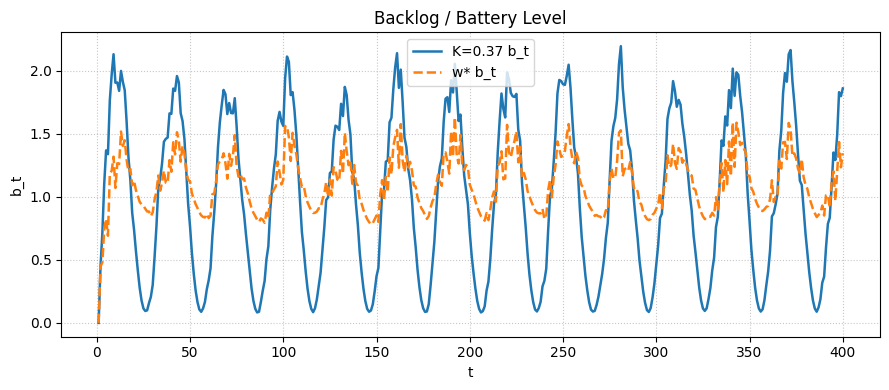

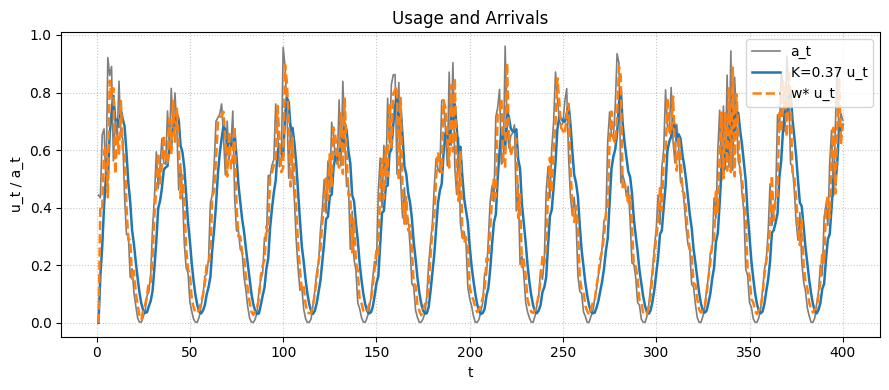

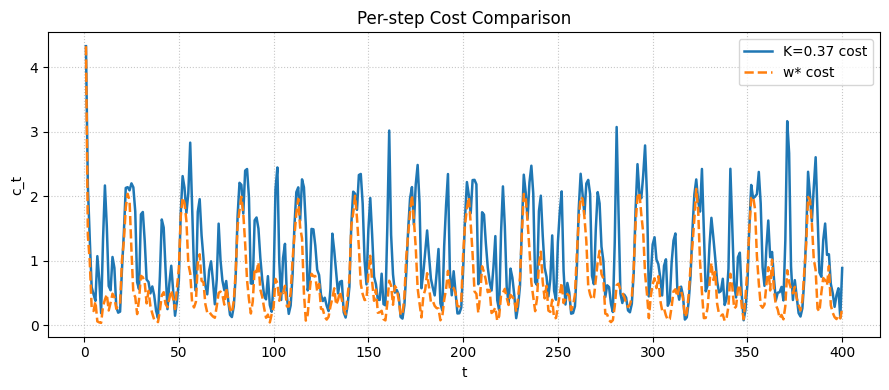


──────────────────────────────
K=0.37          Total cost: 1114.4345
w*              Total cost: 646.0939
──────────────────────────────


{'total_costs': {'K=0.37': 1114.434528392815, 'w*': 646.0938947524811},
 'pairwise_abs_diff': {'K=0.37 vs w*': {'b_diff': 0.4243942552669171,
   'u_diff': 0.09640197631541719,
   'cost_diff': 0.49657907269448304}},
 'total_cost_1': 1114.434528392815,
 'total_cost_2': 646.0938947524811,
 'b_diff': 0.4243942552669171,
 'u_diff': 0.09640197631541719,
 'cost_diff': 0.49657907269448304,
 'plot_window': {'start': 0, 'end': 400}}

In [7]:
# Visual comparison of trajectories and per-step costs
comparison_metrics = compare_controllers(
    sim_constant, f'K={K:.2f}',
    sim_optimal, 'w*',
    a=a,
    plot_start=0,
    plot_end=min(400, T, T),
)
comparison_metrics


Best K on grid: 0.53 with total cost 984.5877
w* total cost : 646.0939


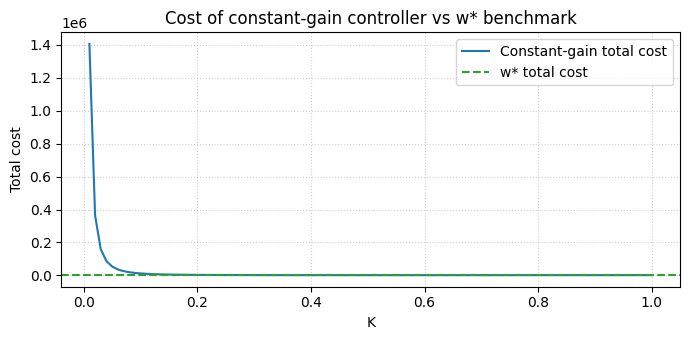

In [8]:
# Sweep over multiple K values to see how the aggregate cost changes
grid_costs = []
for candidate in K_grid:
    sim = simulate_constant_gain(candidate, a, cost_fn, b0=b0)
    grid_costs.append(np.sum(sim['c']))
grid_costs = np.array(grid_costs)
best_idx = int(np.argmin(grid_costs))
best_K = float(K_grid[best_idx])
print(f'Best K on grid: {best_K:.2f} with total cost {grid_costs[best_idx]:.4f}')
print(f'w* total cost : {total_cost_opt:.4f}')

plt.figure(figsize=(7, 3.5))
plt.plot(K_grid, grid_costs, label='Constant-gain total cost')
plt.axhline(total_cost_opt, color='tab:green', linestyle='--', label='w* total cost')
plt.xlabel('K')
plt.ylabel('Total cost')
plt.title('Cost of constant-gain controller vs w* benchmark')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
